In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numba import njit, jit
from itertools import permutations

import random

In [307]:
B = 100
SHINGLES = 2
PERMUTATIONS = 1000
TRESHOLD = 0.8

print(1 - np.power((1 - np.power(TRESHOLD, PERMUTATIONS / B)), B))
print(PERMUTATIONS/B)

0.9999883333978635
10.0


In [308]:
df = pd.read_csv("news_articles_small_monkey.csv")
# df = pd.read_csv("news_articles_large.csv")

print(df.head())

   News_ID                                            article
0        0  The man ate a banana while the monkey looked hurt
1        1  The man ate a banana while the monkey looked j...
2        2  The man ate a coconut while the monkey looked ...
3        3  The man ate a banana while the ape looked jealous
4        4  The Philippine subsidiary of US telecommunicat...


# Jaccard similarity

In [309]:
shingles = SHINGLES
shingles_dict = dict()

In [310]:
def apply_shingles(input):
    s = set()
    l = input.split(' ')
    for ind in range((len(l) - shingles + 1)):
        word = ' '.join(l[ind:ind+shingles])
        if word not in shingles_dict:
            shingles_dict[word] = len(shingles_dict)
        s.add(shingles_dict[word])
    return s
        
df["shingles"] = df["article"].apply(apply_shingles)
print(df.head())

   News_ID                                            article  \
0        0  The man ate a banana while the monkey looked hurt   
1        1  The man ate a banana while the monkey looked j...   
2        2  The man ate a coconut while the monkey looked ...   
3        3  The man ate a banana while the ape looked jealous   
4        4  The Philippine subsidiary of US telecommunicat...   

                                            shingles  
0                        {0, 1, 2, 3, 4, 5, 6, 7, 8}  
1                        {0, 1, 2, 3, 4, 5, 6, 7, 9}  
2                      {0, 1, 2, 5, 6, 7, 9, 10, 11}  
3                      {0, 1, 2, 3, 4, 5, 9, 12, 13}  
4  {14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...  


In [311]:
def similarity(a, b):
    return (len(a & b) / len(a | b))

In [312]:
%%time
similarities = list()
for ind_i, i in enumerate(df["shingles"]):
    for ind_j, j in enumerate(df["shingles"]):
        if ind_i != ind_j:
            similarities.append(similarity(i, j))

hist = np.histogram(similarities, bins=10, range=(0, 1))

CPU times: user 28.4 s, sys: 132 ms, total: 28.5 s
Wall time: 28.5 s


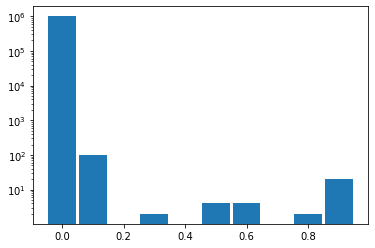

In [313]:
fig, ax = plt.subplots()
ax.bar(hist[1][:-1], hist[0], width=0.09)
ax.set_yscale("log")
plt.show()

# Create minhash

In [314]:
num_perm = PERMUTATIONS
all_shingles = np.array(list(shingles_dict.values()))

permutations = np.zeros(shape=(num_perm, len(all_shingles)), dtype=int)
sign_matrix = np.zeros(shape=(num_perm, len(df.shingles)), dtype=int)

In [315]:
%%time
for i in range(num_perm):
    cont = True
    while cont:
        cont = False
        perm = np.random.permutation(all_shingles)
        for j in range(i):
            if (permutations[j] == perm).all():
                cont = True
    permutations[i] = perm

CPU times: user 1min 26s, sys: 540 ms, total: 1min 27s
Wall time: 1min 27s


In [316]:
%%time
for doc_index, document in enumerate(df.shingles):
    for perm_index, perm in enumerate(permutations):
        for shingle_index, shingle in enumerate(perm):
            if shingle in document:
                sign_matrix[perm_index, doc_index] = shingle_index
                break

CPU times: user 3min 25s, sys: 23 ms, total: 3min 25s
Wall time: 3min 25s


# Locality-Sensitive Hashing

In [317]:
bands = B

13.333333333333334


In [325]:
table = np.split(sign_matrix.T, bands)
htable = [dict()] * bands

candidate_pairs = set()

In [326]:
%%time
for band_index, band in enumerate(table):
    for row_index, row in enumerate(band):
        if row.tostring() in htable[band_index]:
            for candidate in htable[band_index][row.tostring()]:
                candidate_pairs.add((row_index, candidate))
            htable[band_index][row.tostring()].add(row_index)
        else:
            htable[band_index][row.tostring()] = {row_index}

CPU times: user 22.5 ms, sys: 12 µs, total: 22.6 ms
Wall time: 22.2 ms


In [327]:
print(candidate_pairs)

set()


In [321]:
for pair in candidate_pairs:
    print(similarity(df.shingles[pair[0]], df.shingles[pair[1]]))